In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFE
from scipy import stats
import shap


In [3]:
# Loading the data
car = pd.read_csv('Car_preproccesed.csv')
car.head()


,log_price,Mileage,EngineV,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,8.342840,277,2.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,8.974618,427,2.9,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,9.495519,358,5.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,10.043249,240,4.2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,9.814656,120,2.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


In [5]:
# Separate continuous and categorical features
continuous_features = ['Mileage', 'EngineV']
categorical_features = [col for col in car.columns if col not in continuous_features + ['log_price']]

# Declare the feature and target variable
X = car.drop('log_price', axis=1)
y = car['log_price']

X.shape, y.shape


((3867, 17), (3867,))

In [7]:
# Create polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Split the data again
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=32)


In [9]:
# Create instance of scaler
scaler = StandardScaler()

# Scaling the continuous features
X[continuous_features] = scaler.fit_transform(X[continuous_features])

X.head()


,Mileage,EngineV,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,1.217908,-0.474525,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,2.786602,0.473599,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,2.065003,2.685886,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,0.830963,1.843110,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,-0.423992,-0.474525,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


In [11]:
# Use RFE for feature selection
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=10)
fit = rfe.fit(X, y)

# Transform the dataset
X_rfe = fit.transform(X)

# Split the data
X_train_rfe, X_test_rfe, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, random_state=32)


In [13]:
# Ridge Regression with GridSearchCV
ridge = Ridge()
parameters = {'alpha': [0.1, 1, 10, 100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_train_rfe, y_train)

# Best parameters
print(f'Best Parameters: {ridge_regressor.best_params_}')

# Predict on training and testing data
y_pred_train_ridge = ridge_regressor.predict(X_train_rfe)
y_pred_test_ridge = ridge_regressor.predict(X_test_rfe)

# Evaluate the model
r2_train_ridge = r2_score(y_train, y_pred_train_ridge)
rmse_train_ridge = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(y_pred_train_ridge)))
r2_test_ridge = r2_score(y_test, y_pred_test_ridge)
rmse_test_ridge = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_test_ridge)))

print(f'Ridge Regression - R2 Score on Training Data: {r2_train_ridge}')
print(f'Ridge Regression - RMSE on Training Data: {rmse_train_ridge}')
print(f'Ridge Regression - R2 Score on Testing Data: {r2_test_ridge}')
print(f'Ridge Regression - RMSE on Testing Data: {rmse_test_ridge}')


Best Parameters: {'alpha': 0.1}
Ridge Regression - R2 Score on Training Data: 0.6762596881419056
Ridge Regression - RMSE on Training Data: 12701.193193901676
Ridge Regression - R2 Score on Testing Data: 0.6373235253362373
Ridge Regression - RMSE on Testing Data: 14196.366014697986


In [15]:
# Gradient Boosting with GridSearchCV
gb = GradientBoostingRegressor()
parameters = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
gb_regressor = GridSearchCV(gb, parameters, scoring='neg_mean_squared_error', cv=5)
gb_regressor.fit(X_train_rfe, y_train)

# Best parameters
print(f'Best Parameters: {gb_regressor.best_params_}')

# Predict on training and testing data
y_pred_train_gb = gb_regressor.predict(X_train_rfe)
y_pred_test_gb = gb_regressor.predict(X_test_rfe)

# Evaluate the model
r2_train_gb = r2_score(y_train, y_pred_train_gb)
rmse_train_gb = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(y_pred_train_gb)))
r2_test_gb = r2_score(y_test, y_pred_test_gb)
rmse_test_gb = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_test_gb)))

print(f'Gradient Boosting - R2 Score on Training Data: {r2_train_gb}')
print(f'Gradient Boosting - RMSE on Training Data: {rmse_train_gb}')
print(f'Gradient Boosting - R2 Score on Testing Data: {r2_test_gb}')
print(f'Gradient Boosting - RMSE on Testing Data: {rmse_test_gb}')


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Gradient Boosting - R2 Score on Training Data: 0.7460262918681129
Gradient Boosting - RMSE on Training Data: 11113.462222438713
Gradient Boosting - R2 Score on Testing Data: 0.6647150255764225
Gradient Boosting - RMSE on Testing Data: 13225.579026596433


In [17]:
# Train base models
svr_model = SVR(kernel='rbf')
gb_model = GradientBoostingRegressor(random_state=32)
rf_model = RandomForestRegressor(random_state=32)

# Fit base models and generate predictions
svr_model.fit(X_train_rfe, y_train)
gb_model.fit(X_train_rfe, y_train)
rf_model.fit(X_train_rfe, y_train)

# Generate predictions for training and testing data
svr_predictions_train = svr_model.predict(X_train_rfe)
gb_predictions_train = gb_model.predict(X_train_rfe)
rf_predictions_train = rf_model.predict(X_train_rfe)

svr_predictions_test = svr_model.predict(X_test_rfe)
gb_predictions_test = gb_model.predict(X_test_rfe)
rf_predictions_test = rf_model.predict(X_test_rfe)

# Combine predictions into meta-features
meta_features_train = np.column_stack((svr_predictions_train, gb_predictions_train, rf_predictions_train))
meta_features_test = np.column_stack((svr_predictions_test, gb_predictions_test, rf_predictions_test))


In [19]:
# Train meta-model on the base model predictions
meta_model = RandomForestRegressor(random_state=32)
meta_model.fit(meta_features_train, y_train)

# Generate final predictions using the meta-model
final_predictions_train = meta_model.predict(meta_features_train)
final_predictions_test = meta_model.predict(meta_features_test)

# Evaluate the combined model
r2_train_combined = r2_score(y_train, final_predictions_train)
rmse_train_combined = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(final_predictions_train)))
r2_test_combined = r2_score(y_test, final_predictions_test)
rmse_test_combined = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(final_predictions_test)))

print(f'Combined Model - R2 Score on Training Data: {r2_train_combined}')
print(f'Combined Model - RMSE on Training Data: {rmse_train_combined}')
print(f'Combined Model - R2 Score on Testing Data: {r2_test_combined}')
print(f'Combined Model - RMSE on Testing Data: {rmse_test_combined}')


Combined Model - R2 Score on Training Data: 0.8749621113611177
Combined Model - RMSE on Training Data: 8516.952800138924
Combined Model - R2 Score on Testing Data: 0.5386319266413364
Combined Model - RMSE on Testing Data: 13981.750974888384


In [21]:
# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=32)
cv_scores = cross_val_score(meta_model, meta_features_train, y_train, cv=kf, scoring='r2')

print(f'Cross-Validation R2 Scores: {cv_scores}')
print(f'Mean Cross-Validation R2 Score: {np.mean(cv_scores)}')


Cross-Validation R2 Scores: [0.79422826 0.77701347 0.76790911 0.76267418 0.76970159]
Mean Cross-Validation R2 Score: 0.7743053234881444


In [23]:
# Apply log transformation to skewed features
X_log = X.copy()
X_log[continuous_features] = X_log[continuous_features].apply(lambda x: np.log1p(x))

# Split the transformed data
X_train_log, X_test_log, y_train, y_test = train_test_split(X_log, y, test_size=0.2, random_state=32)


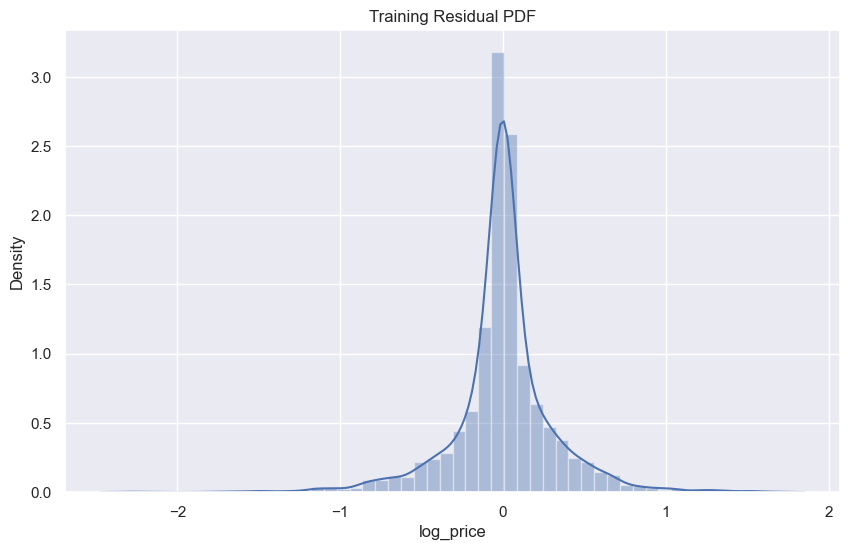

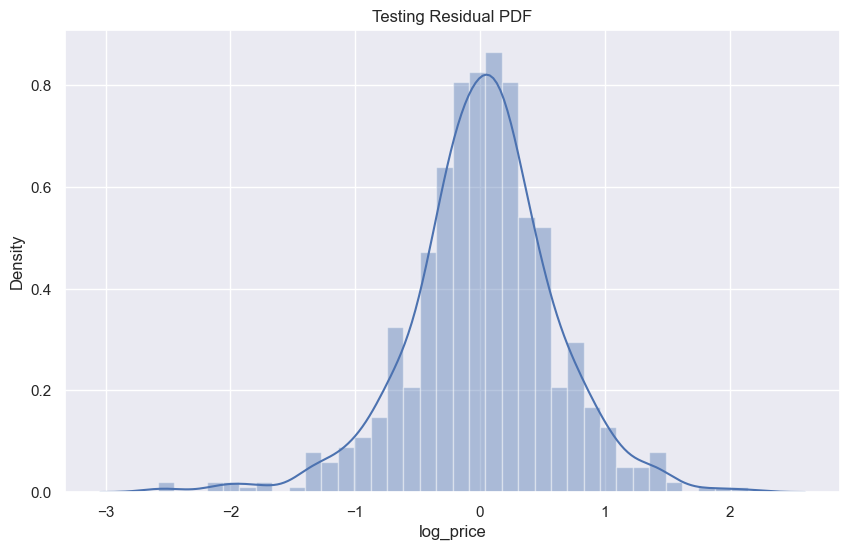

In [25]:
# Plotting the residuals
residual_train = (y_train - final_predictions_train)
plt.figure(figsize=(10,6))
sns.distplot(residual_train)
plt.title('Training Residual PDF')
plt.show()

residual_test = (y_test - final_predictions_test)
plt.figure(figsize=(10,6))
sns.distplot(residual_test)
plt.title('Testing Residual PDF')
plt.show()


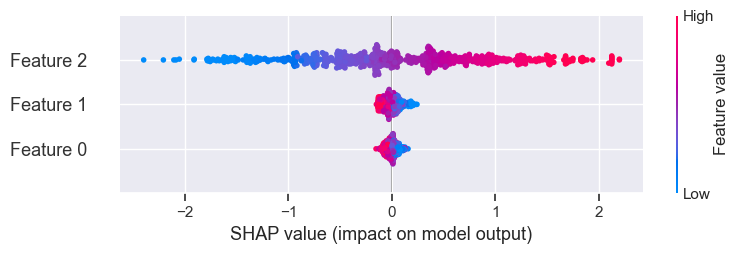

In [27]:
# Use SHAP for model interpretation
explainer = shap.Explainer(meta_model, meta_features_train)
shap_values = explainer(meta_features_test)

# Plot SHAP values
shap.summary_plot(shap_values, meta_features_test)


In [29]:
# Detect and remove outliers using Z-score
z_scores = np.abs(stats.zscore(X))
filtered_entries = (z_scores < 3).all(axis=1)
X_filtered = X[filtered_entries]
y_filtered = y[filtered_entries]

# Split the filtered data
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=32)


In [31]:
# Store models and their metrics in a list of dictionaries
models = [
    {'name': 'Ridge Regression', 'r2_train': r2_train_ridge, 'rmse_train': rmse_train_ridge, 'r2_test': r2_test_ridge, 'rmse_test': rmse_test_ridge},
    {'name': 'Gradient Boosting', 'r2_train': r2_train_gb, 'rmse_train': rmse_train_gb, 'r2_test': r2_test_gb, 'rmse_test': rmse_test_gb},
    {'name': 'Combined Model', 'r2_train': r2_train_combined, 'rmse_train': rmse_train_combined, 'r2_test': r2_test_combined, 'rmse_test': rmse_test_combined},
]

# Find the best model based on R² Score on Testing Data
best_r2_model = max(models, key=lambda x: x['r2_test'])

# Find the best model based on RMSE on Testing Data
best_rmse_model = min(models, key=lambda x: x['rmse_test'])

# Output the results
print(f"Best model based on R2 Score (Testing Data): {best_r2_model['name']}")
print(f"  R2 Score on Testing Data: {best_r2_model['r2_test']}")
print(f"  RMSE on Testing Data: {best_r2_model['rmse_test']}\n")

print(f"Best model based on RMSE (Testing Data): {best_rmse_model['name']}")
print(f"  R2 Score on Testing Data: {best_rmse_model['r2_test']}")
print(f"  RMSE on Testing Data: {best_rmse_model['rmse_test']}")


Best model based on R2 Score (Testing Data): Gradient Boosting
  R2 Score on Testing Data: 0.6647150255764225
  RMSE on Testing Data: 13225.579026596433

Best model based on RMSE (Testing Data): Gradient Boosting
  R2 Score on Testing Data: 0.6647150255764225
  RMSE on Testing Data: 13225.579026596433
